# Header

In [ ]:
# !pip install transformers
# !pip install sentencepiece
# !pip install rouge-score


In [2]:
import json
import os
import stanza
import numpy as np
import pandas as pd
import re
import torch 
import time

from underthesea import sent_tokenize as sent_tokenize_uts, word_tokenize as word_tokenize_uts
from rouge_score import rouge_scorer
from tqdm import tqdm

from sklearn.utils import shuffle

from transformers import RobertaModel, RobertaTokenizerFast

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import LSTM, Conv2d, Linear
from torch.nn.functional import max_pool2d
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

2021-10-11 10:47:04.750820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda-10.1/lib64
2021-10-11 10:47:04.750856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
text = 'Sống với nhau như vợ_chồng nhưng không đăng_ký kết_hôn , đến khi chia_tay , Cường giành quyền nuôi con không được nên đã mang xăng đến cửa_hàng của “ vợ ” để đốt . Đối_tượng đang bị cơ_quan công_an truy bắt .'
sent_tokenize_uts(text), word_tokenize_uts(text, format='text')

(['Sống với nhau như vợ_chồng nhưng không đăng_ký kết_hôn , đến khi chia_tay , Cường giành quyền nuôi con không được nên đã mang xăng đến cửa_hàng của “ vợ ” để đốt .',
  'Đối_tượng đang bị cơ_quan công_an truy bắt .'],
 'Sống với nhau như vợ_chồng nhưng không đăng_ký kết_hôn , đến khi chia_tay , Cường giành quyền nuôi con không được nên đã mang xăng đến cửa_hàng của “ vợ ” để đốt . Đối_tượng đang bị cơ_quan công_an truy bắt .')

# Data pre-processing

In [2]:
base_dir = 'data/vietnews/data'

def get_files(name):
    dir = os.path.join(base_dir, name)
    return [os.path.join(dir, file) for file in os.listdir(dir)]
    
train_files = get_files('train_tokenized')
valid_files = get_files('val_tokenized')
test_files = get_files( 'test_tokenized')

In [20]:
LOWER = False
LENGTH_THRESHOLD = 15
rouge_factors = {'rouge1': 0.3, 'rouge2': 0.3, 'rougeL': 0.4}  

def sent_tokenize(doc):
    return sent_tokenize_uts(doc)

def word_tokenize(text, format='list'):
    return word_tokenize_uts(text, format=format)

def parse_file(file):
    with open(file, encoding='utf-8') as f:
        document = f.read().rstrip().split("\n\n")
    for i in range(len(document)):
        document[i] = [text for text in document[i].split('\n') if len(text) > 0]
        
    if len(document) < 4:
        title, summary, doc = document 
        img_caption = ''
    else:
        title, summary, doc, img_caption = document 
    summary = sent_tokenize(summary[0])
    return title, summary, doc, img_caption


def make_label(doc, sum, scorer):
    doc_size = len(doc)
    res = [0] * doc_size
    n = min(len(sum), doc_size)
    # f1 of rouge-L
    for j in range(n):
        score = [scorer.score(sum[j], sent_i) for sent_i in doc]
        score = [( 
            x['rouge1'][2] * rouge_factors['rouge1'] + \
            x['rouge2'][2] * rouge_factors['rouge2'] + \
            x['rougeL'][2] * rouge_factors['rougeL']
            ) for x in score]
        sent_pos = np.argmax(score)
        for i in range(doc_size):
            if res[sent_pos] == 1:
                score[sent_pos] = 0
                sent_pos = np.argmax(score)
            else:
                res[sent_pos] = 1
                break
        # print(score[sent_pos])
        # print(doc[sent_pos])
        # print(sum[j], "\n")
    return res

def process(files):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    img_captions = {}
    titles = {}
    docs = {}
    summaries = {}
    labels = {}
    remove_files = []
    for idx in tqdm(range(len(files))):
        # if idx%1000 == 0:
        #     print('\n', os.getpid(), idx)
        title, summary, doc, img_caption = parse_file(os.path.join(files[idx]))
        # print(title, summary, doc, img_caption)
        if len(doc) < len(summary) or len(doc) == 0 or len(summary) == 0:
            remove_files.append(files[idx])   
            continue    
        label = make_label(doc, summary, scorer)
        titles[files[idx]] = title
        docs[files[idx]] = doc
        labels[files[idx]] = label
        summaries[files[idx]] = summary
        img_captions[files[idx]] = img_caption
        # if idx%5000 == 0:
        #     a = list(zip(label, doc))
        #     for i in a:
        #         print(len(i[1]), i[0], i[1])
        #     print('##########\n','\n'.join(summary))
    return titles, docs, labels, summaries, img_captions, remove_files

def json_dump(obj, file):
    with open(file, 'w', encoding='utf8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=4)

def process_and_write(files, write_dir):
    titles, docs, labels, summaries, img_captions, remove_files = process(files)

    os.makedirs(write_dir, exist_ok=True)
    json_dump(docs, os.path.join(write_dir, 'docs.json'))
    json_dump(labels, os.path.join(write_dir, 'labels.json'))
    json_dump(summaries, os.path.join(write_dir, 'summaries.json'))
    json_dump(titles, os.path.join(write_dir, 'titles.json'))
    json_dump(img_captions, os.path.join(write_dir, 'img_captions.json'))
    json_dump(remove_files, os.path.join(write_dir, 'remove_files.json'))


In [21]:
base_write_dir = 'data/viet_new_processed'
process_and_write(valid_files[:100], os.path.join(base_write_dir, 'valid'))
process_and_write(test_files[:100], os.path.join(base_write_dir, 'test'))
process_and_write(train_files[:100], os.path.join(base_write_dir, 'train'))

100%|██████████| 100/100 [00:03<00:00, 29.16it/s]


In [25]:
import numpy as np
import json

with open('data/viet_new_processed/train/labels.json') as f:
    labels = json.load(f)

labels = list(labels.values())
length = [np.sum(x) for x in labels]
print(length)
np.histogram(length, bins=len(set(length)))

[1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


(array([84, 15,  1]), array([1., 2., 3., 4.]))

# Data processing

In [18]:
class VietnewsConfig:
    def __init__(self):
        self.train_data_dir = 'data/viet_new_processed/train'
        self.val_data_dir = 'data/viet_new_processed/valid'
        self.test_data_dir = 'data/viet_new_processed/test'

        self.bert_type = RobertaModel
        self.tokenizer_type = RobertaTokenizerFast
        self.bert_name = 'Zayt/viRoberta-l6-h384-word-cased'  # my Roberta pretrained model on  4gb of text

        self.MAX_SEQ_LEN = 96
        self.MAX_DOC_LEN = 32

        self.bert_hidden = 384
        self.bert_n_layers = 3

        self.windows_size = [1, 3, 5, 10]
        self.out_channels = 50
        self.lstm_hidden = 256
        self.device = 'cuda:3'

        self.batch_size = 6
        self.num_epochs = 7
        self.warmup_steps = 500
        self.gradient_accumulation_steps = 16
        self.print_freq = 0.05
        self.save_dir = './save/vietnews'

config = VietnewsConfig()
# config.__dict__

In [20]:
tokenizer = config.tokenizer_type.from_pretrained(config.bert_name)

def load_json(file):
    with open(file) as f:
        return json.load(f)

def load_text(dir, return_sum=False):
    docs = load_json(os.path.join(dir, 'docs.json'))
    labels = load_json(os.path.join(dir, 'labels.json'))
    if return_sum:
        summaries = load_json(os.path.join(dir, 'summaries.json'))
        return docs, labels, summaries
    return docs, labels

def get_encodings(docs, labels, config=config):
    keys = list(docs.keys())
    encodings = []
    return_labels = []

    for k in tqdm(keys):
        encodings.append(tokenizer(docs[k][:config.MAX_DOC_LEN], truncation=True,
                                   max_length=config.MAX_SEQ_LEN, padding='max_length',
                                   ))
        return_labels.append(labels[k][:config.MAX_DOC_LEN])
    
    return keys, encodings, return_labels



In [30]:
class ESDataset(Dataset):
    def __init__(self, encodings, labels=None, keys=None):
        self.encodings = encodings
        self.labels = labels
        self.keys = keys
        self.encoding_keys = ['input_ids', 'attention_mask']

    def __getitem__(self, idx):
        item = {key: torch.tensor(self.encodings[idx][key]) for key in self.encoding_keys}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings)

def collate_fn(data):
    keys = data[0].keys()

    result = {k: [item[k] for item in data] for k in keys}
    input_ids = result['input_ids']
    result['document_mask'] = [torch.tensor([1] * len(input_ids[i])) for i in range(len(input_ids))]
    
    for k in result:
        if k != 'labels':
            result[k] = pad_sequence(result[k], batch_first=True)
    
    return result


In [26]:
train_texts, train_dict_labels = load_text(config.train_data_dir)
val_texts, val_dict_labels = load_text(config.val_data_dir)

train_keys, train_encodings, train_labels = get_encodings(train_texts, train_dict_labels)
val_keys, val_encodings, val_labels = get_encodings(val_texts, val_dict_labels)

# dataset = ESDataset(val_encodings, val_labels, val_keys)
# val_loader = DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

  1%|          | 584/105400 [00:07<22:23, 78.01it/s] 


KeyboardInterrupt: 

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0., 361157.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
        104, 112, 120, 128, 136, 144, 152]),
 <a list of 19 Patch objects>)

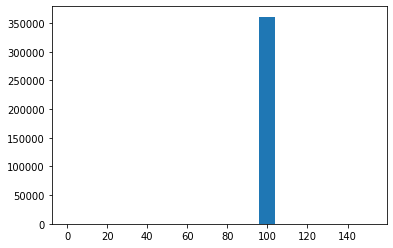

In [22]:
import matplotlib.pyplot as plt
length = []
for encoding in val_encodings:
    length.extend([len(sent) for sent in encoding['input_ids']])
# np.histogram(length, bins=[8*i for i in range(0, 20)])
plt.hist(length, bins=[8*i for i in range(0, 20)])

# Model

In [23]:
bert = config.bert_type.from_pretrained(config.bert_name)
tokenizer = config.tokenizer_type.from_pretrained(config.bert_name)

Downloading:   0%|          | 0.00/703 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0M [00:00<?, ?B/s]

Some weights of the model checkpoint at Zayt/viRoberta-l6-h384-word-cased were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at Zayt/viRoberta-l6-h384-word-cased and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

In [38]:
class Bert_Embedding(nn.Module):
    def __init__(self, bert: RobertaModel, config: VietnewsConfig):
        super(Bert_Embedding, self).__init__()
        self.bert = bert
        self.bert_hidden = config.bert_hidden * config.bert_n_layers
        self.get_n_layers = config.bert_n_layers
        self.config = config
        
        self.windows_size = config.windows_size
        self.out_channels = config.out_channels
        self.lstm_embedding_size = len(self.windows_size) * config.MAX_SEQ_LEN  
        self.filters = nn.ModuleList([nn.Conv2d(1, self.out_channels,
                                                (i, self.bert_hidden)) for i in self.windows_size])
        self.relu = nn.ReLU()
        
    def forward(self, x, document_mask, attention_mask):
        lens = [mask_i.sum().item() for mask_i in document_mask]

        batch, doc_len, seq_len = list(x.shape)
        x = x.reshape((batch*doc_len, seq_len))
        attention_mask = attention_mask.reshape((batch*doc_len, seq_len))        

        last_hds, pooler_output, hidden_states = self.bert(x, attention_mask, output_hidden_states=True, return_dict=False)
        embeddings = torch.cat(hidden_states[-self.get_n_layers:], axis=-1)  # batch, doc_len, seq_len, self.bert_hidden
        # print(embeddings.shape)
        embeddings = embeddings.reshape((batch * doc_len, 1,  seq_len, self.bert_hidden))  # batch * doc_len, 1, MAX_SEQ_LEN, bert_hidden
        lstm_inputs = []

        for i in range(len(self.windows_size)):
            temp_out = self.filters[i](embeddings).squeeze(-1)  # batch * doc_len, self.out_channels, MAX_SEQ_LEN - self.windows_size[i] + 1
            cnn_result = torch.mean(temp_out, dim=1) # average along out_channels axis
            if cnn_result.shape[1] < self.config.MAX_SEQ_LEN: # pad cnn_result to MAX_SEQ_LEN
                pad_tensor = torch.zeros((cnn_result.shape[0], self.config.MAX_SEQ_LEN - cnn_result.shape[1])).to(cnn_result.device)
                cnn_result = torch.cat([cnn_result, pad_tensor], axis=1)
            lstm_inputs.append(cnn_result)
        lstm_inputs = torch.cat(lstm_inputs, dim=-1).reshape((batch, doc_len, self.lstm_embedding_size)) 
        lstm_inputs = lstm_inputs * torch.nn.functional.sigmoid(lstm_inputs)  # Swish 
        lstm_inputs = pack_padded_sequence(lstm_inputs, lens, batch_first=True, enforce_sorted=False)

        return lstm_inputs


class Document_Encoder(nn.Module):
    def __init__(self, embedding_size, config: VietnewsConfig):
        super(Document_Encoder, self).__init__()

        self.config = config
        self.embedding_size = embedding_size
        self.doc_encoder = nn.LSTM(self.embedding_size, config.lstm_hidden, num_layers=1,
                            bidirectional=True, batch_first=True)

    def forward(self, lstm_inputs):
        _, doc_encoder_out = self.doc_encoder(lstm_inputs)

        return doc_encoder_out

class Sentence_Extractor(nn.Module):
    def __init__(self, embedding_size, config: VietnewsConfig):
        super(Sentence_Extractor, self).__init__()

        self.config = config
        self.embedding_size = embedding_size
        self.sentence_extractor = nn.LSTM(self.embedding_size, config.lstm_hidden, num_layers=1,
                                  bidirectional=True, batch_first=True)
        self.dropout_layer = nn.Dropout(0.3)

    def forward(self, lstm_inputs, encoder_in):
        out_packed, (_, __) = self.sentence_extractor(lstm_inputs, encoder_in)
        out, out_lens = pad_packed_sequence(out_packed, batch_first=True)
        out = self.dropout_layer(out)
        return out

class Model(nn.Module):
    def __init__(self, bert, config: VietnewsConfig):
        super(Model, self).__init__()
        self.config = config
        self.embeddings = Bert_Embedding(bert, config=config)
        self.doc_encoder = Document_Encoder(self.embeddings.lstm_embedding_size, config=config)
        self.sentence_extractor = Sentence_Extractor(self.embeddings.lstm_embedding_size, config=config)

        self.linear = Linear(config.lstm_hidden * 2, 1) 
        self.loss_func = nn.BCELoss()
        self.loss_padding_value = -100
        self.softmax = nn.Softmax(dim=-1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, document_mask, attention_mask, y=None):
        lstm_inputs = self.embeddings(x, document_mask, attention_mask)

        doc_encoder_out = self.doc_encoder(lstm_inputs)  
        encoder_in = doc_encoder_out

        out = self.sentence_extractor(lstm_inputs, encoder_in)
        out = self.sigmoid(self.linear(out).squeeze(-1))
        # print(out.shape, mask.shape)
        # out *= mask
        
        if y is not None:
            y = pad_sequence(y, batch_first=True, padding_value=self.loss_padding_value).type(torch.FloatTensor).to(out.device)
            loss = self.loss_func(out, y)
            out = nn.functional.softmax(out, dim=-1)
            return out, loss

        return nn.functional.softmax(out, dim=-1)

    def predict(self, tokenizer, doc):
        pass

In [42]:
## Test model
# model = Model(bert, config).to(config.device)

for item in val_loader:
    ids = item['input_ids'].to(config.device)
    document_mask = item['document_mask'].to(config.device)
    attention_mask = item['attention_mask'].to(config.device)
    print(model(ids, document_mask, attention_mask).shape)
    break

# config.__dict__

torch.Size([4, 23])


/mnt/disk1/tan_hm/venv/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Train

In [34]:
from datetime import datetime
from sklearn.metrics import classification_report, f1_score

def torch_save(dir, save_dict):
    os.makedirs(dir, exist_ok=True)

    for name in save_dict:
        torch.save(save_dict[name], os.path.join(dir, name + '.pt'))
    
def torch_load_all(dir):
    save_dict = {}
    for name in os.listdir(dir):
        save_dict[name.replace('.pt', '')] = torch.load(os.path.join(dir, name), map_location=torch.device('cpu'))

    return save_dict



def train(model, train_loader, val_loader, optimizer=None, scheduler=None, config=config, start_epoch=0):
    model.train()
    all_train_loss, all_dev_loss, all_dev_f1 = [], [], []
    best_dev_loss = 1e9
    best_dev_f1 = 0

    print_freq = config.print_freq
    batch_size = config.batch_size
    epochs = config.num_epochs
    gradient_accumulation_steps = config.gradient_accumulation_steps
    save_dir = config.save_dir

    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3, epochs=epochs, steps_per_epoch=len(train_loader.dataset))
    print_after = int(print_freq * len(train_loader.dataset) / batch_size)
    for epoch in range(start_epoch, epochs):
        print_counter = 0
        total_loss = []
        print('Epoch {} started on {}'.format(epoch, datetime.now().strftime('%d/%m/%Y %H:%M:%S')))
        for step, item in enumerate(tqdm(train_loader)):
            ids = item['input_ids'].to(config.device)
            document_mask = item['document_mask'].to(config.device)
            attention_mask = item['attention_mask'].to(config.device)
            label = item['labels']
            logits, loss = model(ids, document_mask, attention_mask, y=label)
            
            loss = loss / gradient_accumulation_steps
            loss.backward()
            if (step+1) % gradient_accumulation_steps == 0 or step == len(train_loader.dataset)-1:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            total_loss.append(loss.item())
            if step > print_counter:
                print('Step: {}, loss: {}, total loss: {}'.format(step, loss.item(), np.mean(total_loss)))
                print_counter += print_after
        
        print('Train loss:', np.mean(total_loss))
        all_train_loss.append(total_loss)
        result_dict = {'epoch': epoch, 'all_train_loss': all_train_loss}
        model_name = 'model_{}.pt'.format(epoch)

        save_dict = {
            'model_state_dict': model.state_dict(),
            'config': config,
            # 'optimizer_state_dict': optimizer.state_dict() if optimizer is not None else None,
            # 'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
            'result_dict': result_dict
            }
        if val_loader is not None:
            dev_loss, dev_f1 = eval(model, val_loader, config)
            all_dev_loss.append(dev_loss)
            all_dev_f1.append(dev_f1)
            print('Dev loss: {}, Dev F1: {}'.format(dev_loss, dev_f1))

            custom_save_dict = {
                'model_state_dict': model.state_dict(),
                'config': config,
                'result_dict': result_dict
            }
            if dev_loss < best_dev_loss:
                torch_save(os.path.join(save_dir, 'best-model-loss'), custom_save_dict)
                best_dev_loss = dev_loss
            if dev_f1 > best_dev_f1:
                torch_save(os.path.join(save_dir, 'best-model-f1'), custom_save_dict)
                best_dev_f1 = dev_f1

            result_dict.update ({
                'all_dev_loss': all_dev_loss,
                'all_dev_f1': all_dev_f1,
                'best_dev_loss': best_dev_loss,
                'best_dev_f1': best_dev_f1
                })

        
        torch_save(os.path.join(save_dir, 'checkpoint_{}'.format(epoch)), save_dict)

        # torch_save(os.path.join(save_dir, 'model_{}.pt'.format(str(epoch))),
        #            model, config, epoch, optimizer, scheduler, all_train_loss, all_dev_loss, best_dev_loss)
        print('Finish epoch {} on {}. \n'.format(epoch, datetime.now().strftime('%d/%m/%Y %H:%M:%S')))
 

def eval(model, val_loader, config=config, get_report=True):
    model.eval()
    total_loss = []
    y_pred = []
    y_true = []


    with torch.no_grad():
        for item in val_loader:
            ids = item['input_ids'].to(config.device)
            document_mask = item['document_mask'].to(config.device)
            attention_mask = item['attention_mask'].to(config.device)
            labels = item['labels']
            logits, loss = model(ids, document_mask, attention_mask, y=labels)
            
            prob = logits
            batch_y_true = []
            batch_y_pred = [[] for i in range(len(labels))]
            for j, sent in enumerate(labels):
                last_index = len(labels[j])
                batch_y_true.extend(labels[j])
                temp_prob = np.argsort(prob[j, :last_index].tolist())
                batch_y_pred[j] = [0] * len(sent)
                # Get top 4 best sentence
                for k in temp_prob[-4:]:
                    batch_y_pred[j][k] = 1
            y_true.extend(batch_y_true)
            for sent in batch_y_pred:
                y_pred.extend(sent)
            total_loss.append(loss.item())

    if get_report:
        print(classification_report(y_true, y_pred))
        
    model.train()    
    
    return np.mean(total_loss), f1_score(y_true, y_pred)

In [28]:
model = Model(bert).to(config.device)

In [44]:
val_dataset = ESDataset(val_encodings[:100], val_labels, val_keys)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

train_dataset = ESDataset(train_encodings[:10000], train_labels, train_keys)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


train(model, train_loader, val_loader)

# Test

In [45]:
final_dict = torch_load_all('save/vietnews/best-model-f1')

model = Model(bert, config).to(config.device)
model.load_state_dict(final_dict['model_state_dict'])

<All keys matched successfully>

In [40]:
from rouge_score import rouge_scorer
import numpy as np
import os
import pandas as pd

# model.load_state_dict(torch.load(ROOT_DIR+'/save/best-model.pt'))
# model.to('cuda')
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)
alpha = 0.9


def get_test_loader(docs, config=config):
    encodings = []
    for doc in docs:
        encodings.append(tokenizer(doc[:config.MAX_DOC_LEN], truncation=True,
                                   max_length=config.MAX_SEQ_LEN, padding='max_length'))
    
    test_dataset = ESDataset(encodings)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    return test_loader


def get_all_probs(model, all_doc, config=config):
    res = []
    test_loader = get_test_loader(all_doc, config=config)
    for item in tqdm(test_loader):
        ids = item['input_ids'].to(config.device)
        document_mask = item['document_mask'].to(config.device)
        attention_mask = item['attention_mask'].to(config.device)
        prob = model(ids, document_mask, attention_mask)[0].tolist()
        res.append(prob)
            
    return res

def calculateSimilarity(sentence, doc):
    score = scorer.score('\n'.join(doc), sentence)
    return np.mean([score['rouge2'][2], score['rougeLsum'][2]])

def choose_summary_mmr(doc, prob, k=3):
    prob = np.array(prob)
    idx = [np.argmax(prob)]
    prob[idx[0]] = 0
    summary = [doc[idx[0]]]

    while len(idx) < min(k, len(doc)):
        mmr = -100 * np.ones_like(prob)
        for i, sent in enumerate(doc):
            if prob[i] != 0:
                mmr[i] = alpha * prob[i] - (1-alpha) * calculateSimilarity(sent, summary)
        pos = np.argmax(mmr)
        prob[pos] = 0
        summary.append(doc[pos])
        idx.append(pos)
    summary = sorted(list(zip(idx, summary)), key=lambda x: x[0])
    return [x[1] for x in summary]

def choose_summary(doc, prob, k=3):
    idx = torch.topk(torch.tensor(prob), k=k).indices.tolist()
    return [doc[i] for i in sorted(idx)]


def test(documents, summaries, all_probs, choose_summary=choose_summary, k=3, save_dir='./'):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)
    res = {'rouge1': [], 'rouge2': [], 'rougeLsum': []}
    for i, document in enumerate(tqdm(documents)):
        processed_document = document[: len(all_probs[i])]
        score = scorer.score('\n'.join(summaries[i]), '\n'.join(choose_summary(processed_document, all_probs[i], k))) # target, prediction
        for cate in res:
            res[cate].append(score[cate][2])  # f1 score
        # print(i, [res[cate][-1] for cate in res])
    print('\n\nResult :')
    for i in res:
        x = np.mean(res[i])
        print(i, x)
        res[i].extend([0.10101, x])
    # res['doc_id'] = list(range(len(documents))) + ['0.10101', 'None']

    # df = pd.DataFrame.from_dict(res)
    # df.to_csv(os.path.join(save_dir, 'result200.csv'), index=False)

In [41]:
test_texts, test_dict_labels, test_summaries = load_text(config.test_data_dir, return_sum=True)
model.to(config.device)

test_ids = list(test_texts.keys())
docs = [test_texts[i] for i in test_ids]
summaries = [test_summaries[i] for i in test_ids]
probs = get_all_probs(model, docs)
test(docs, summaries, probs, choose_summary)

  0%|          | 0/1093 [00:00<?, ?it/s]/mnt/disk1/tan_hm/venv/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1093/1093 [00:04<00:00, 225.35it/s]



Result :
rouge1 0.3102072385848451
rouge2 0.12535380813127672
rougeLsum 0.2760824764243371


In [16]:
probs

[[0.09986606240272522,
  0.07213430106639862,
  0.09388574957847595,
  0.07409825921058655,
  0.18170563876628876,
  0.11890880763530731,
  0.08771233260631561,
  0.07143262028694153,
  0.13012860715389252,
  0.07012753933668137]]